# Deep Learning and Its Applications to Signal and Image Processing and Analysis - Assignment 3


## Introduction
In this assignment, you will perform an image classification task on the CIFAR-10 dataset using two
model families: Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs). The objectives
are to develop models, apply explainability tools (Grad-CAM and attention visualization), and evaluate
comparative performance using confusion matrices and other metrics. In this assignment, you will also
learn how to use the pytorch-lightning library. This library simplifies model building and training, and
it also supports automatic logging to Weights & Biases. There is a complementary notebook attached
to the assignment. A complementary notebook is provided with this assignment. It is intended for your
convenience, and you are free to modify it as needed.

### Imports and mount drive - in this notebook i will work on my own pc. so do not need to use colab syntax

In [1]:
from typing import Any

import numpy as np
# skip this
# !pip install pytorch-lightning
# skip that
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Subset

import pytorch_lightning as pl


import wandb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🧹 Set seeds and configs
pl.seed_everything(42)

Seed set to 42


42

In [2]:
# skip this
# from google.colab import drive
# drive.mount('/content/drive')
# skip that

In [3]:
import os
# os.chdir('')

## 1. CNN Classification and Grad-CAM Explainability

In this section, you will implement a CNN from scratch and apply Grad-CAM to explain the model predictions.

###  1.1. Load and Preprocess CIFAR-10

a. load dataset:

In [4]:
# Define a transform to normalize the data
# Widely‑used baseline
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

# Source for values: https://github.com/kuangliu/pytorch-cifar/issues/19
# Source2 for values: https://stackoverflow.com/questions/69747119/pytorch-cifar10-images-are-not-normalized

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

#⬇️ Load dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


a.plot sample images:

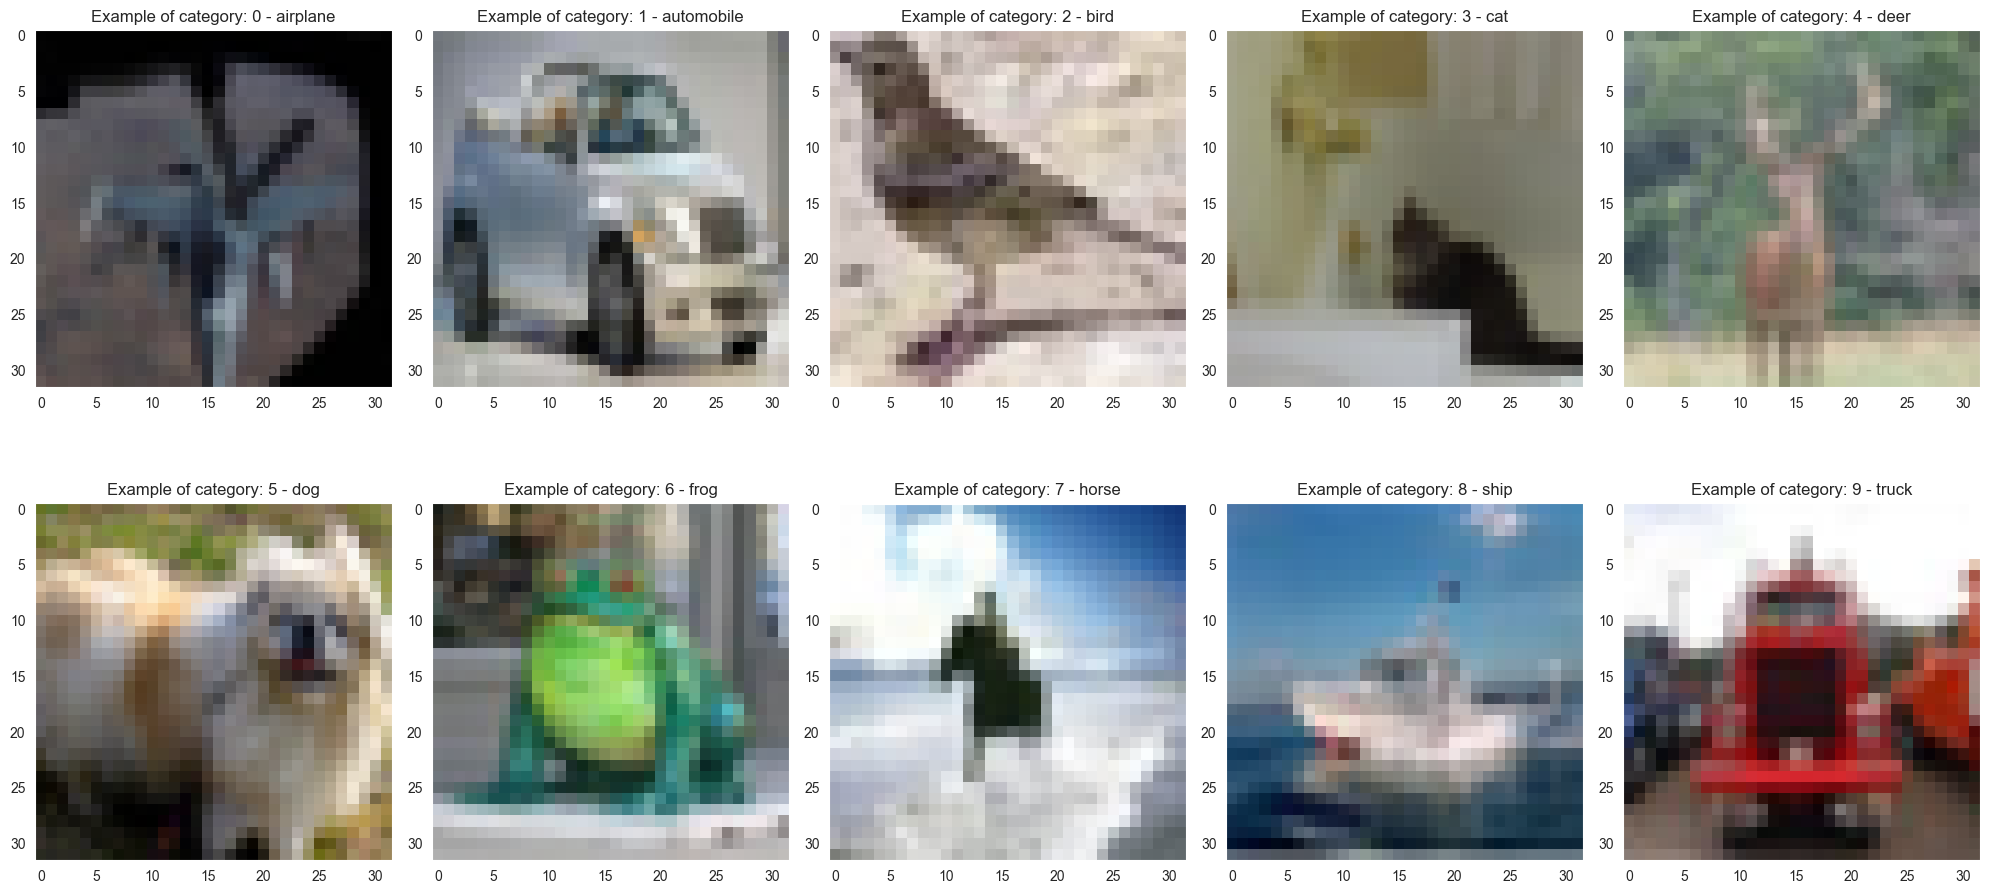

In [5]:
import random
import numpy as np
def get_class_name_from_idx(dictionary,idx):
    for key, value in dictionary.items():
        if value == idx:
            return key
def show_example_per_label(dataset):
    sample_targets = []
    sample_indices = []
    random.seed(234)
    for k,target in enumerate(dataset.targets):
        if random.random() < 0.05: # get different images every time
            if not target in sample_targets:
                sample_indices.append(k)
                sample_targets.append(target)
    sorted_indices_by_target = np.argsort(sample_targets)

    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

    row = 0
    index = 0
    switchbool= False
    for k in sorted_indices_by_target:
        axs[row,index]. grid(False)
        axs[row,index].set_title(f"Example of category: {sample_targets[k]} - {get_class_name_from_idx(dataset.class_to_idx,sample_targets[k])}")
        axs[row,index].imshow(dataset.data[sample_indices[k]])
        index+=1
        if index > 4 and switchbool== False:
            switchbool = True
            row = 1
            index = 0
    fig.tight_layout()
    plt.show()
show_example_per_label(dataset)

b. split - 30k train, 20k valid, 10k test (50,33.33,16.66)

In [6]:
from sklearn.model_selection import train_test_split
targets = dataset.targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)), test_size=0.4, random_state=24, shuffle=True, stratify=targets)

train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, valid_idx)

print("Train dataset:" + str(len(train_dataset)))
print("Validation dataset:" + str(len(validation_dataset)))
print("Test dataset:" + str(len(test_dataset)))


Train dataset:30000
Validation dataset:20000
Test dataset:10000


c. preview categories histogram in each dataset

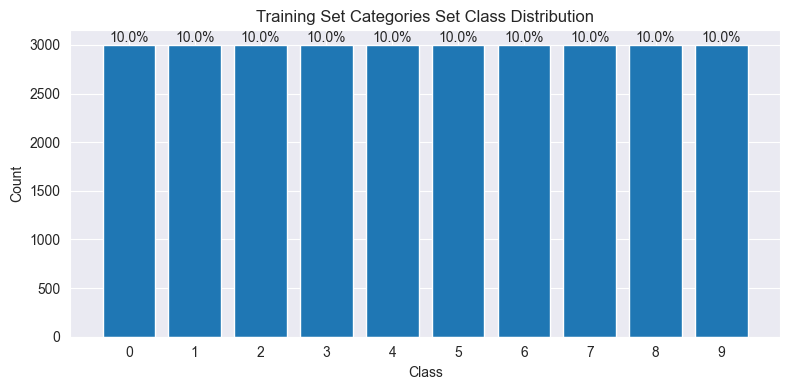

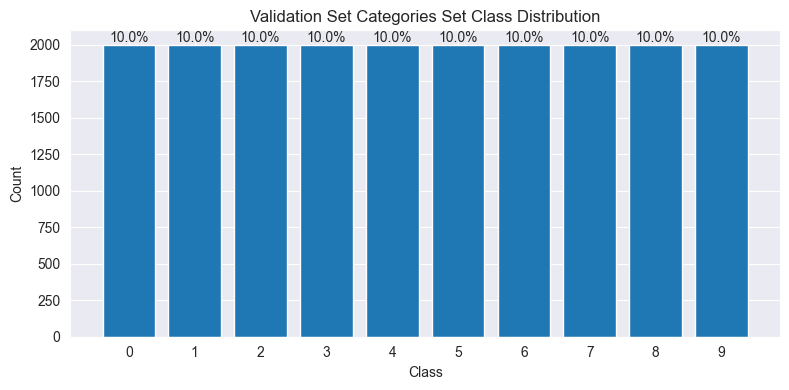

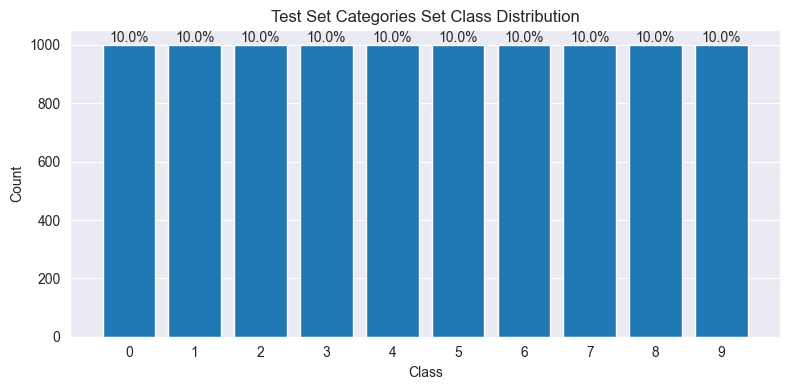

In [7]:
def plot_categories_histograms(set,header):
    # Extract class labels from the original dataset (Subset stores indices)
    # Supports subset or full dataset via try except mechanism on input
    try:
        labels = [set.dataset.targets[i] for i in set.indices]
    except:
        labels = [set.targets[i] for i in range(len(set.targets))]
    # Creating histogram dicts:
    counting_dict={}
    for k in range(10):
        counting_dict[k]=0
    # Count occurrences of each class
    for i,value in enumerate(np.array(labels)):
        counting_dict[value] +=1

    # Extract class indices and corresponding counts
    classes = list(counting_dict.keys())
    counts = [counting_dict[k] for k in classes]

    total = sum(counts)
    percentages = [count / total * 100 for count in counts]

    # Plotting training set histogram
    plt.figure(figsize=(8, 4))
    bars = plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{header} Set Class Distribution')
    plt.xticks(classes)
    plt.tight_layout()

    # Add percentage labels on top of bars
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height , f'{percent:.1f}%',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_categories_histograms(train_dataset, 'Training Set Categories')
plot_categories_histograms(validation_dataset, 'Validation Set Categories')
plot_categories_histograms(test_dataset, 'Test Set Categories')

###  1.2. Define CNN in PyTorch Lightning

a.

In [9]:
import torchmetrics
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

class SimpleCNN(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)
        self.val_acc   = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)
        self.test_acc  = torchmetrics.Accuracy(task="multiclass",
                                               num_classes=10)

        self.test_f1  = torchmetrics.F1Score(
            task='multiclass', num_classes=10,average=None)

        self.test_cm  = torchmetrics.ConfusionMatrix(
            task='multiclass', num_classes=10)

        def conv_bn_relu(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True)
            )

        # 3×32×32 → 256×8×8
        self.features = nn.Sequential(
            conv_bn_relu(3,   64),
            conv_bn_relu(64,  64),
            nn.MaxPool2d(2),          # 64×16×16

            conv_bn_relu(64, 128),
            conv_bn_relu(128,128),
            nn.MaxPool2d(2),          # 128×8×8

            conv_bn_relu(128,256),
            conv_bn_relu(256,256)
        )

        self.gap     = nn.AdaptiveAvgPool2d(1)      # 256×1×1
        self.dropout = nn.Dropout(0.3)
        self.fc      = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).flatten(1)   # B×256
        x = self.dropout(x)
        return self.fc(x)

    #     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    #     self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
    #                             padding=1)
    #     self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
    #     self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
    #                             padding=1)
    #     self.linear_1 = nn.Linear(4096, 300)
    #     self.relu_1 = nn.ReLU()
    #     self.linear_2 = nn.Linear(300, 10)
    #
    # def forward(self, x):
    #     x = self.relu_1(self.conv_1(x)) # in: 3x32X32, out: 16x32X32
    #     x = self.relu_1(self.conv_2(x)) # in: 16x32X32, out: 32x32X32
    #     x = self.mp(x) # in: 32X32X32, out: 32X16X16
    #     x = self.relu_1(self.conv_3(x)) # in: 32X16X16, out: 64x16X16
    #     x = self.mp(x) # in: 64x16X16, out: 64x8X8
    #     x = x.reshape(x.size(0), -1) # 64x8x8 = 4096
    #     x = self.relu_1(self.linear_1(x)) # input 4096, output: 300
    #     x = self.linear_2(x) # input 300, output: 3
    #     return x



    def training_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.train_acc.update(preds,y)
        self.log("train_acc",self.train_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('train loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.val_acc.update(preds,y)
        self.log("val_acc",self.val_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('validation loss', loss, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        loss, preds, y = self.common_step(batch, batch_idx)
        self.test_acc.update(preds,y)
        self.test_f1.update(preds, y)
        self.test_cm.update(preds, y)
        self.log("test_acc",self.test_acc,
                 on_step=False,on_epoch=True,prog_bar=True)
        self.log('test loss', loss, prog_bar=True)
        return loss

    def common_step(self, batch, batch_idx):
        x,y = batch
        scores = self.forward(x)
        loss = self.loss(scores, y)
        return loss, scores, y

    def predict_step(self,batch,batch_idx):
        x,y = batch
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        return preds

    def on_test_epoch_end(self):
        def plot_f1_scores(f1):
            f1 = f1.detach().cpu().numpy()
            class_names = [str(i) for i in range(10)]
            fig, ax = plt.subplots(figsize=(8, 5))
            bars = ax.bar(class_names, f1, alpha=0.7, edgecolor='black')

            ax.set_xlabel("Class")
            ax.set_ylabel("F1 score")
            ax.set_title(f"Per class F1 (macro ≈ {f1.mean():.4f})")
            ax.set_ylim(0, 1.1)
            ax.grid(axis='y', linestyle='--', alpha=0.5)

            for bar, score in zip(bars, f1):
                ax.text(bar.get_x() + bar.get_width() / 2,
                        score + 0.02,
                        f"{score:.2f}",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

            fig.tight_layout()
            return fig

        def plot_conf_matrix(conf_mat):
            conf_mat = conf_mat.detach().cpu().numpy()
            row_sums = conf_mat.sum(axis=1, keepdims=True)
            conf_norm = np.divide(conf_mat, row_sums)
            n_classes = conf_norm.shape[0]
            class_names = [str(i) for i in range(n_classes)]
            df = pd.DataFrame(conf_norm, index=class_names, columns=class_names)

            fig, ax = plt.subplots(figsize=(8, 6))
            sns.heatmap(
                df,
                annot=True,
                fmt=".2f",
                cmap="Blues",
                vmin=0, vmax=1,
                cbar=True,
                ax=ax
            )
            ax.set_xlabel("Predicted label")
            ax.set_ylabel("True label")
            ax.set_title("Confusion matrix (row normalised)")
            fig.tight_layout()

            return fig

        f1_per_class =  self.test_f1.compute()
        fig1 = plot_f1_scores(f1_per_class)
        conf_mat = self.test_cm.compute()
        fig2 = plot_conf_matrix(conf_mat)


        self.logger.log_image("f1_scores",[fig1])
        self.logger.log_image("confusion_matrix",[fig2])

        self.test_f1.reset()
        self.test_cm.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [10]:
from pytorch_lightning.callbacks import EarlyStopping

BATCH_SIZE = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


b. Your model should achieve an accuracy of at least 0.80 on the training set, and at least 0.70 on both the validation and test sets.

In [11]:
# 🪄 Init wandb logger
wandb_logger = WandbLogger(project="CNN-CIFAR10", log_model=True)

# ⚡ Instantiate model and trainer
model = SimpleCNN()

# Define the checkpoint callback
early_stop = EarlyStopping(monitor="validation loss",mode="min", patience=5, verbose=True)
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="validation loss", mode="min",verbose=True)

trainer = pl.Trainer(accelerator="gpu",devices=[0],min_epochs=5,max_epochs=30,callbacks=[early_stop,checkpoint_callback],logger=wandb_logger)

trainer.fit(model,train_loader,validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: ndvamr (ndvamr-ben-gurion-university-of-the-negev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | loss      | CrossEntropyLoss          | 0      | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | test_f1   | MulticlassF1Score         | 0      | train
5 | test_cm   | MulticlassConfusionMatrix | 0      | train
6 | features  | Sequential                | 1.1 M  | train
7 | gap       | AdaptiveAvgPool2d         | 0      | train
8 | dropout   | Dropout                   | 0      | train
9 | fc        | Linear                    | 2.6 K  | train
----------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.595     Total estimated model params size (MB)
36        Modules in train mode
0         Module

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\ndvam\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\ndvam\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved. New best score: 1.295
Epoch 0, global step 118: 'validation loss' reached 1.29475 (best 1.29475), saving model to '.\\CNN-CIFAR10\\inc7hjum\\checkpoints\\epoch=0-step=118.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.143 >= min_delta = 0.0. New best score: 1.152
Epoch 1, global step 236: 'validation loss' reached 1.15153 (best 1.15153), saving model to '.\\CNN-CIFAR10\\inc7hjum\\checkpoints\\epoch=1-step=236.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 354: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.278 >= min_delta = 0.0. New best score: 0.874
Epoch 3, global step 472: 'validation loss' reached 0.87373 (best 0.87373), saving model to '.\\CNN-CIFAR10\\inc7hjum\\checkpoints\\epoch=3-step=472.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.173 >= min_delta = 0.0. New best score: 0.700
Epoch 4, global step 590: 'validation loss' reached 0.70047 (best 0.70047), saving model to '.\\CNN-CIFAR10\\inc7hjum\\checkpoints\\epoch=4-step=590.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 708: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 826: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 944: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1062: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric validation loss improved by 0.011 >= min_delta = 0.0. New best score: 0.690
Epoch 9, global step 1180: 'validation loss' reached 0.68957 (best 0.68957), saving model to '.\\CNN-CIFAR10\\inc7hjum\\checkpoints\\epoch=9-step=1180.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1298: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1416: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1534: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1652: 'validation loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric validation loss did not improve in the last 5 records. Best score: 0.690. Signaling Trainer to stop.
Epoch 14, global step 1770: 'validation loss' was not in top 1


c.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ndvam\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7746000289916992     │
│      validation loss      │    0.6895726323127747     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ndvam\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test loss         │    1.0602436065673828     │
│         test_acc          │    0.7459999918937683     │
└───────────────────────────┴───────────────────────────┘

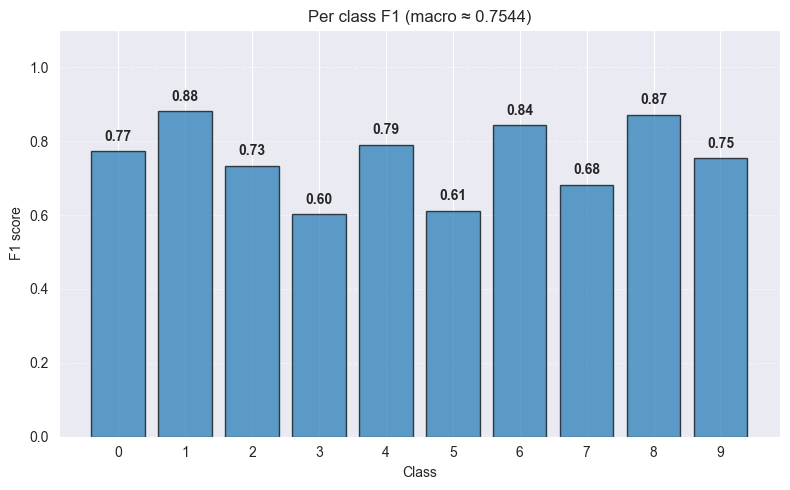

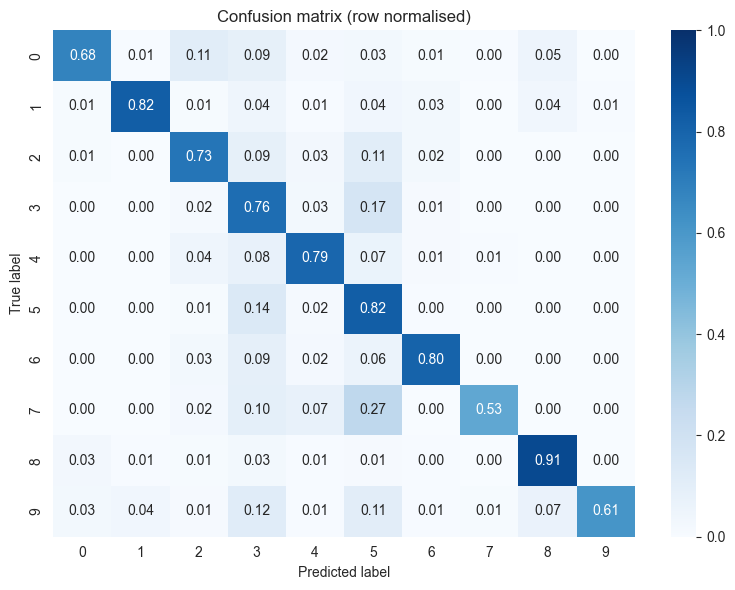

In [21]:
# 🔍 Evaluate
best_model = SimpleCNN.load_from_checkpoint(checkpoint_callback.best_model_path)

trainer.validate(model=best_model,dataloaders=validation_loader)

trainer.test(model, dataloaders=test_loader)

#Show F1 score and confusion matrix you can do it in def on_test_epoch_end(self): and log it to wandb

# 💾 Save the model in thr last epoch if saved by metric  
trainer.save_checkpoint("cnn_cifar10_best.ckpt")

## 1.3 Explainability with Grad-CAM

a.

In [13]:
# !pip install grad-cam --quiet

In [84]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# load the model again
model = SimpleCNN.load_from_checkpoint("cnn_cifar10_best.ckpt")
model.eval()

# Define the target layer for Grad-CAM (adjust if needed)
target_layer = model.features[-1][0]

cam = GradCAM(model=model, target_layers=[target_layer])


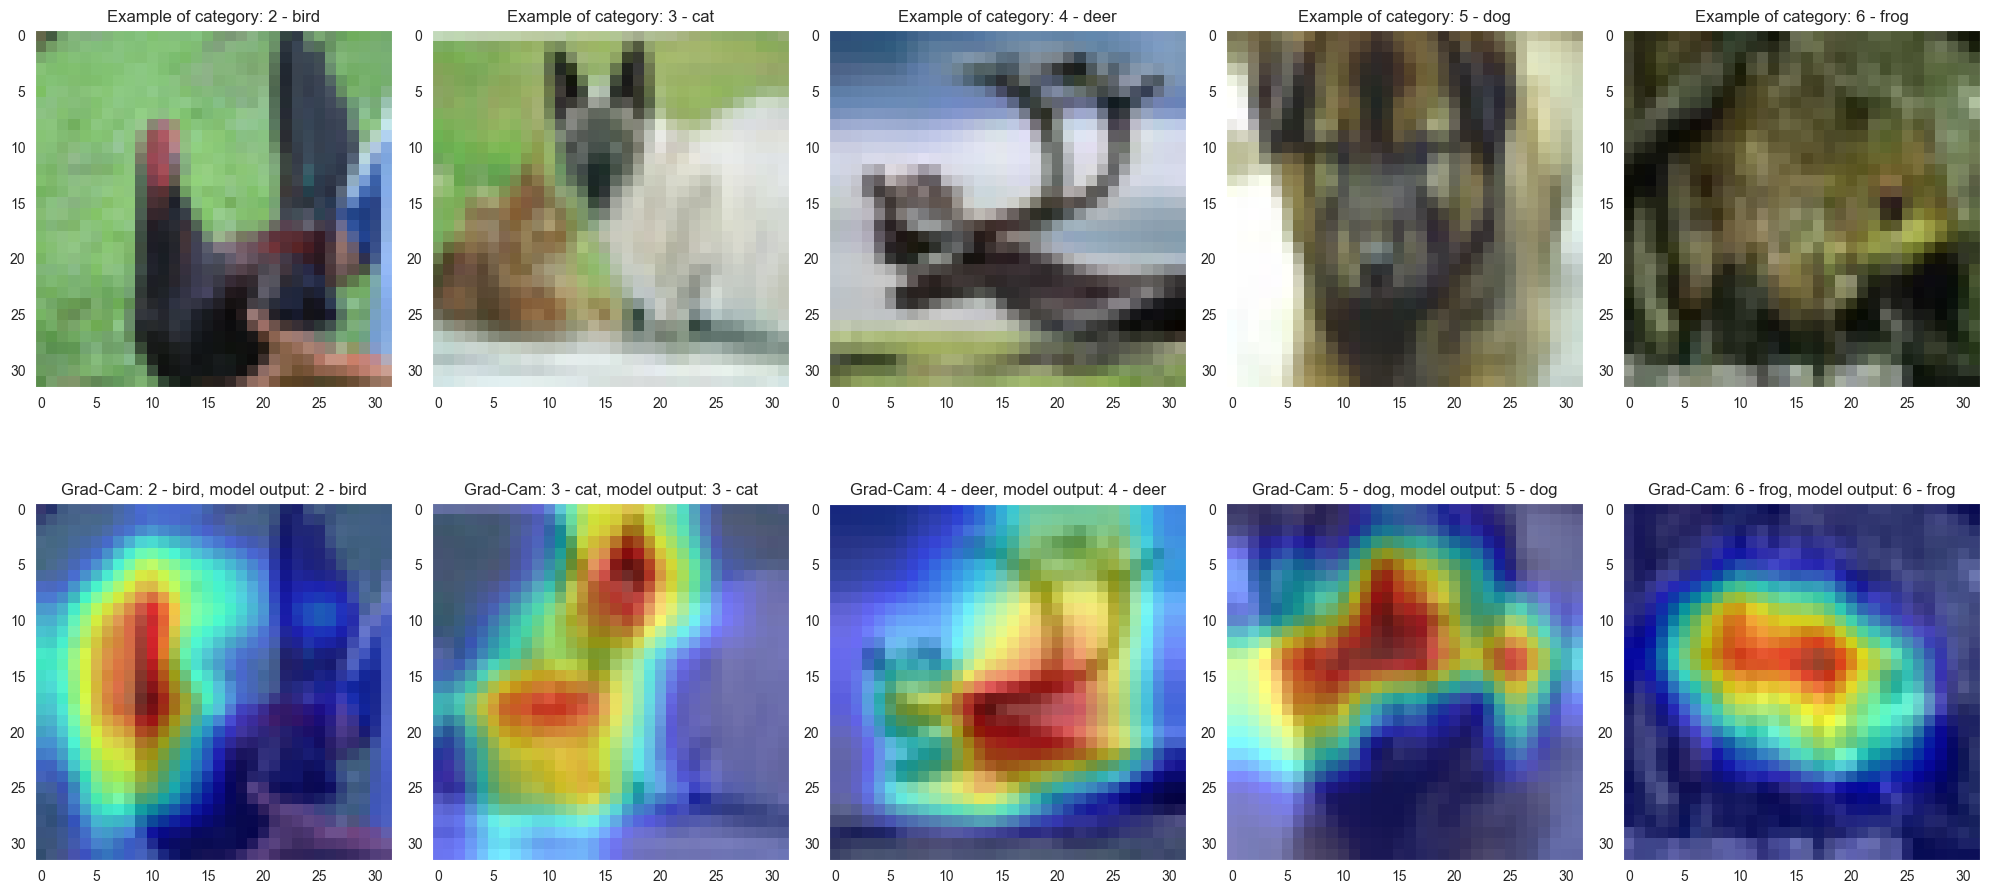

In [123]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import random
import numpy as np

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

def get_class_name_from_idx(dictionary,idx):
    for key, value in dictionary.items():
        if value == idx:
            return key
def show_example_per_label(dataset):
    sample_targets = []
    sample_indices = []
    random.seed(978)
    for k,target in enumerate(dataset.targets):
        if random.random() < 0.1:
            if not target in sample_targets:
                sample_indices.append(k)
                sample_targets.append(target)
    sorted_indices_by_target = np.argsort(sample_targets)

    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

    index = 0
    for k in sorted_indices_by_target[2:7]:

        rgb_img = dataset.data[sample_indices[k]]/255.0
        category = sample_targets[k]
        axs[0,index]. grid(False)
        axs[0,index].set_title(f"Example of category: {category} - {get_class_name_from_idx(dataset.class_to_idx,sample_targets[k])}")
        axs[0,index].imshow(rgb_img)

        input_tensor = preprocess_image(rgb_img,mean=cifar10_mean,std=cifar10_std).float()

        # Show what model predicted
        with torch.no_grad():
            logits = model(input_tensor)
            probs = logits.softmax(dim=1).squeeze(0)
            pred_idx  = int(probs.argmax())

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(category)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        axs[1,index]. grid(False)
        axs[1,index].set_title(f"Grad-Cam: {category} - {get_class_name_from_idx(dataset.class_to_idx,sample_targets[k])}, model output: {pred_idx} - {get_class_name_from_idx(dataset.class_to_idx,pred_idx)}")
        axs[1,index].imshow(visualization)
        index += 1
        if index == 5:
             break
    fig.tight_layout()
    plt.show()

show_example_per_label(test_dataset)


# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])
# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# # You can also get the model outputs without having to redo inference
# model_outputs = cam.outputs
# plt.imshow(visualization); plt.axis("off"); plt.show()

generate Grad-CAM heatmaps for several test images

In [51]:
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
# Construct the CAM object once, and then re-use it on many images.


rgb_img = test_dataset.data[0]
input_tensor = preprocess_image(rgb_img,mean=cifar10_mean,std=cifar10_std)
# -- 5.  Run Grad‑CAM ---------------------------------------------
with torch.inference_mode():
    grayscale_cam = cam(input_tensor=input_tensor)  # list‑like, len = batch
grayscale_cam = grayscale_cam[0]                   # H×W   (first/only image)

# -- 6.  Overlay heat‑map on the RGB image ------------------------
vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(vis); plt.axis("off"); plt.show()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## 2. Vision Transformer (ViT) and Attention Visualization


In this section, you will implement a Vision Transformer (ViT) from scratch and compare it to the CNN
model developed in Section 1. Additionally, you will visualize attention maps to gain insight into the
model’s decision process.

### 2.1 Implementing the Vision Transformer

a.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=..., patch_size=..., emb_size=..., img_size=...):
      raise NotImplementedError("TODO: Implement this part")

    def forward(self, x):
      raise NotImplementedError("TODO: Implement this part")

class ViTWithAttention(nn.Module):
  def __init__(self, img_size=..., patch_size=..., in_channels=..., num_classes=...,):
    raise NotImplementedError("TODO: Implement this part")

  def forward(self, x):
    raise NotImplementedError("TODO: Implement this part")

class ViTLightningModule(pl.LightningModule):
  def __init__(self, lr=...):
    raise NotImplementedError("TODO: Implement this part")

  def forward(self, x):
    raise NotImplementedError("TODO: Implement this part")

  def training_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")

  def validation_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")
  
  def test_step(self, batch, batch_idx):
    raise NotImplementedError("TODO: Implement this part")

  def configure_optimizers(self):
    raise NotImplementedError("TODO: Implement this part")

b. Your model should achieve an accuracy of at least 0.70 on the training set, and at least 0.60 on both the validation and test sets.

In [ ]:
# 🪄 Init wandb logger
wandb_logger = WandbLogger(project="ViT-CIFAR10", log_model=True)

# ⚡ Instantiate model and trainer
model = ViTLightningModule(lr=...)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    # raise NotImplementedError("TODO: Implement this part")
)

trainer = pl.Trainer(
    # raise NotImplementedError("TODO: Implement this part")
)

# 🏋️‍♂️ Train
trainer.fit(model, train_loader, val_loader)

c.

In [ ]:
# 🔍 Evaluate
trainer.test(model, dataloaders=test_loader)

#Show F1 score and confusion matrix you can do it in def on_test_epoch_end(self): and log it to wandb

### 2.2 Visualizing Attention Maps

In [ ]:
def visualize_attention(model, image_tensor, patch_size=4):
    raise NotImplementedError("TODO: Implement this part")
